In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d.head()

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61


In [3]:
# Add lagged returns as features
return_1d['Nifty_CMDT_1d_return'] = return_1d['Nifty_CMDT_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_CMDT_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_CMDT_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_CMDT_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_CMDT_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_CMDT_1d_return'] >= lower_bound) & (return_1d['Nifty_CMDT_1d_return'] <= upper_bound)]
np.random.seed(42)

In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
13-09-11               -0.95               -0.36               0.31   
14-09-11              -13.25                2.14               0.48   
15-09-11               -0.13                0.31               0.28   
19-09-11               -7.11               -2.41              -2.72   
20-09-11               -3.09               -1.07              -0.83   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
13-09-11              0.35            -0.30                1.97   
14-09-11              0.07            -2.42               -0.68   
15-09-11             -0.16             4.74                2.96   
19-09-11             -1.62             0.01               13.07   
20-09-11              1.39            -1.47               -1.08   

          Gold_1d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1794.000000         1794.000000        1794.000000   
mean            -1.295825           -2.512336           0.441583   
std             74.248387          135.645238          44.451860   
min          -2807.010000        -3606.010000        -363.000000   
25%             -1.977500           -1.880000          -2.010000   
50%             -0.880000           -1.000000          -1.000000   
75%              0.247500           -0.060000          -0.110000   
max            904.410000         3322.270000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1794.000000      1794.000000         1794.000000     1794.000000   
mean          -2.455741        -2.207486           -0.999989       -0.938567   
std           64.692398        23.175244            2.298979       10.500736   
min        -1517.720000      -426.1

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_CMDT_1d_return'].sort_values())
nifty_corr_1d

,Nifty_CMDT_1d_return
return_squared,-0.595354
return_lag_interaction,-0.056358
NASDAQ_1d_return,-0.044512
Nifty_Consumer_1d_return,-0.023188
Inr_Usd_1d_return,-0.018057
Dow_Jons_1d_return,-0.016717
Dollar_Index_1d_return,-0.014937
NIFTY_FIN_SERVICE_1d_return,-0.011170
Nifty_Energy_1d_return,-0.008512
Bank_Nifty_1d_return,-0.008275


<Axes: >

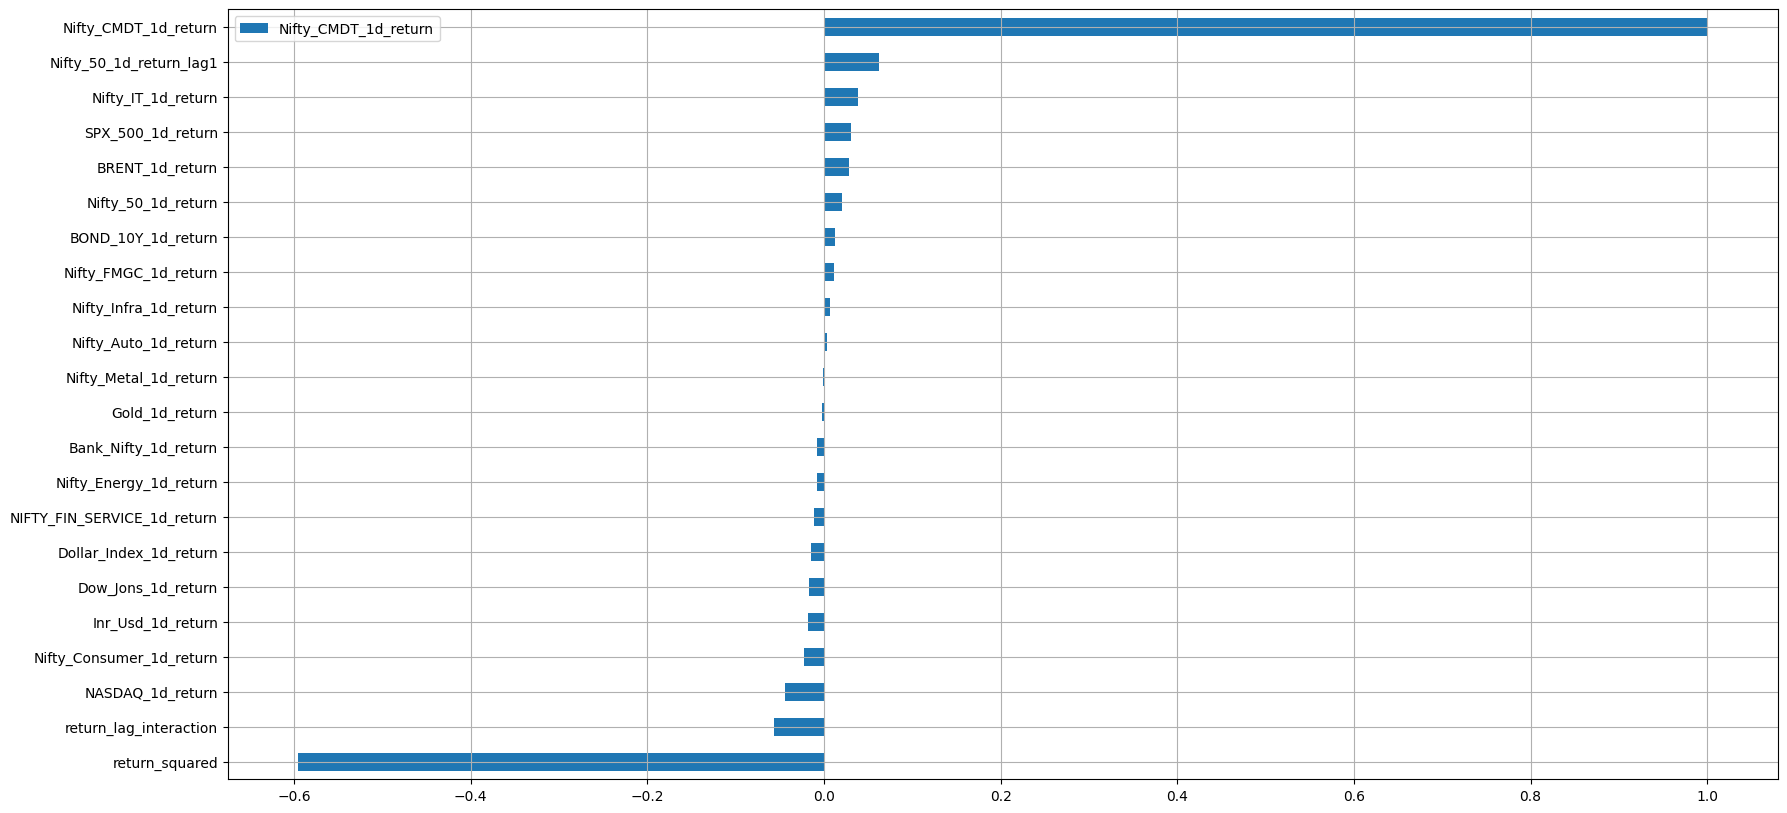

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1d.drop(columns='Nifty_CMDT_1d_return')
y = return_1d['Nifty_CMDT_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Nifty_50_1d_return', 'Dow_Jons_1d_return', 'SPX_500_1d_return',
       'NASDAQ_1d_return', 'BRENT_1d_return', 'BOND_10Y_1d_return',
       'Gold_1d_return', 'Inr_Usd_1d_return', 'Dollar_Index_1d_return',
       'Bank_Nifty_1d_return', 'Nifty_IT_1d_return', 'Nifty_Auto_1d_return',
       'Nifty_Metal_1d_return', 'Nifty_FMGC_1d_return',
       'Nifty_Energy_1d_return', 'NIFTY_FIN_SERVICE_1d_return',
       'Nifty_Infra_1d_return', 'Nifty_Consumer_1d_return',
       'Nifty_50_1d_return_lag1', 'return_squared', 'return_lag_interaction'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_CMDT_1d_return')
y = return_1d['Nifty_CMDT_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 2.09928357e-03  2.14024823e-02  1.55758874e+00 -3.72701899e-01
   1.06068840e-01 -7.17914888e-01 -1.03015075e-01  3.40052417e-01
  -8.61442023e-02 -1.06303032e-01  2.72290728e-04 -4.12706004e-01
  -3.19563067e-02 -1.73285756e-02 -9.65192572e-03  2.74862990e-02
  -1.32973510e-01 -5.59794786e-02  2.22725980e-02 -5.82002733e-01
  -2.78275766e-02]
 [ 3.04232786e-03  9.67746083e-03 -3.58146279e-02  2.04987147e-02
   4.00317106e-02 -1.78394617e-01 -2.20182384e-01 -1.76268450e-01
   1.06952622e-02 -1.31783565e-01 -8.01523599e-02 -1.69283586e-01
   8.76225776e-02 -3.88547244e-02  1.22199856e-02 -5.28614332e-02
  -1.10873645e-01 -2.72368115e-02  7.79051877e-03 -6.27504999e-01
  -2.54772799e-02]
 [ 6.94922564e-03 -2.70461915e-02 -4.50311028e-01  1.27187045e-01
  -2.60054188e-02  1.05728084e+00  4.27296266e-02  3.62728671e-01
  -1.51576273e-01 -6.06003030e-04 -5.03276538e-03 -8.83675464e-02
   2.75511098e-02 -2.29962198e-02  3.66982387e-01 -3.50317799e-02
   3.42822833e-02 -3.99805938e-03 -4.1

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.3515
R2: 0.8026

For RFR:
MSE: 0.1126
R2: 0.9367

For ETR:
MSE: 0.5748
R2: 0.6772

For GBR:
MSE: 0.1389
R2: 0.9220

For XGBR:
MSE: 0.0956
R2: 0.9463



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.0956.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.0956.

In [16]:
y_pred = etr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
24-02-20,-1.11,-1.0198
14-12-12,0.20,-0.0072
20-10-21,-2.11,-2.0286
02-04-14,-0.67,-0.3488
06-05-20,-1.01,-0.8482
...,...,...
24-06-19,-1.29,-1.0808
12-12-22,-3.17,-2.1630
29-04-22,-2.20,-1.6816


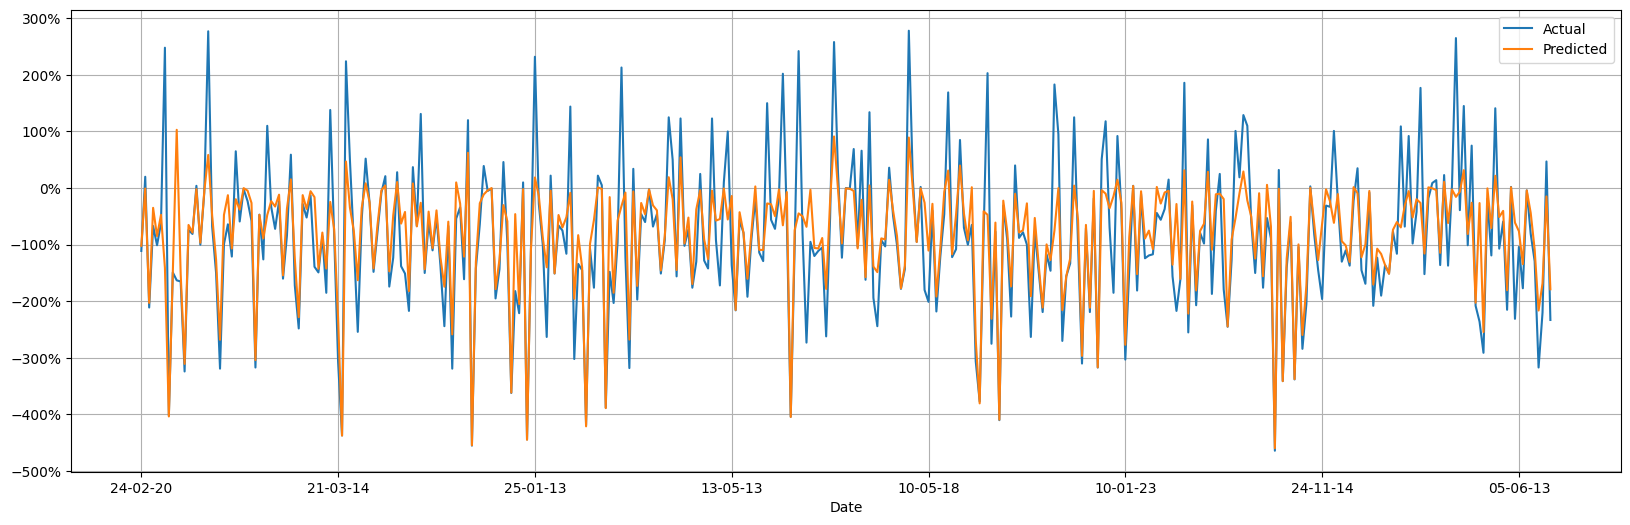

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_13732\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_CMDT_1d_return', ylabel='Density'>

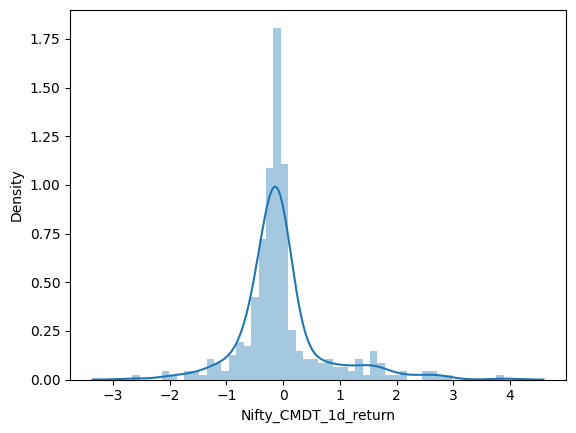

In [18]:
sns.distplot(y_test-y_pred)

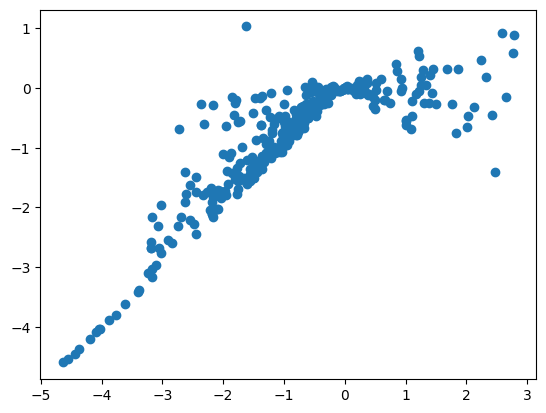

In [19]:
plt.scatter(y_test,y_pred)
